In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
import dgl
sys.path.append('.')

from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
# from dataset import *k
from days import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
from time import time
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

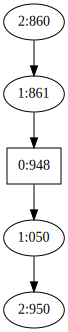

In [3]:
graph_file = '/beegfs/ua349/archive/data/graphs/400861-400948_n2.json'
segs, adjlist = read_graph(graph_file,
                         verbose=False, named_adj=True)
rootseg = segs[0]
len(segs)

dmap = compute_depth(segs, adjlist)
graph = show_graph(segs, adjlist, vdesc=lambda vert: '%s:%s' % (str(dmap[vert]), vert[-3:]) )
graph

In [4]:
dset = DayHistory(segs, 'train', bsize=32)#.generator()
valset = DayHistory(segs, 'test', bsize=32)#.generator()

Full history
 [*] Segments: 90 co-avail
    * [400861-400948]: 90 (25.5% nan)
    * [400860-400861]: 90 (6.1% nan)
    * [400948-404050]: 90 (34.5% nan)
    * [404050-400950]: 90 (41.9% nan)
    * [401348-400860]: 90 (45.4% nan)
 [*] Examples (train): 72
 [*] Time range: 2014-08-01 ~ 2014-10-31
Full history
 [*] Segments: 90 co-avail
    * [400861-400948]: 90 (25.5% nan)
    * [400860-400861]: 90 (6.1% nan)
    * [400948-404050]: 90 (34.5% nan)
    * [404050-400950]: 90 (41.9% nan)
    * [401348-400860]: 90 (45.4% nan)
 [*] Examples (test): 18
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [5]:
print(len(dset.data), len(dset.rawdata))
print(dset.rawdata[0].shape, dset.rawdata[1].shape)

72 90
(81, 5) (89, 5)


In [6]:
n_lag = 24

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('/home/ua349/dgl/examples/pytorch/gcn')
from gcn import GCN
# sys.path.append('/home/ua349/dgl/examples/pytorch/gat')
# from gat import GraphAttention

g = dgl.DGLGraph()
g.add_nodes(len(segs))
source_list  = []
sink_list = []
iindex = { seg:ind for ind, seg in enumerate(segs) }
for source, ls in adjlist.items():
    for sink in ls:
        source_list.append(iindex[source])
        sink_list.append(iindex[sink])
        # TWOWAY
        source_list.append(iindex[sink])
        sink_list.append(iindex[source])
g.add_edges(source_list, sink_list) # add 4 edges 0->1, 0->2, 0->3, 0->4
# g

n_edges = g.number_of_edges()

# normalization
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0
norm = norm.cuda()
g.ndata['norm'] = norm.unsqueeze(1)
# norm

gcn = GCN(g,
    in_feats=n_lag,
    n_hidden=64,
    n_classes=1,
    n_layers=2,
    activation=F.relu,
    dropout=0.5).cuda()

In [61]:
loss_fcn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(
    gcn.parameters(),
    lr=1e-3,
    weight_decay=5e-4)

In [62]:
def nan_amount(arr):
    nans = np.isnan(arr).sum()
    return nans / len(arr.flat)

def trainable_inds(data):
    inds = []
    for di, daydata in enumerate(data):
        for hi, hrdata in enumerate(daydata):
            if hi < n_lag + 1:
                continue
            if nan_amount(data[di][hi-n_lag:hi]) < 0.5:
                if nan_amount(data[di][hi:hi+1]) < 0.5:
                    inds.append((di, hi))
    print('Gathered traiing: %d' % len(inds))
    
    return inds
inds = trainable_inds(dset.data)

n2t = lambda arr: torch.from_numpy(np.array(arr)).cuda().float()
def format_batch(inds, data, squeeze=True):
    batch = []
    labels = []
    lmasks = []
    for di, hi in inds:
        X = data[di][hi-n_lag:hi].T.copy()
        X[np.isnan(X)] = -1
        Y = data[di][hi:hi+1].T.copy()
        mask = np.logical_not(np.isnan(Y))
        
        batch.append(X)
        labels.append(Y)
        lmasks.append(mask)
        
    lmasks = torch.ByteTensor(np.array(lmasks)).squeeze(0)    
    batch, labels = [n2t(ls).squeeze(0) for ls in [batch, labels]]

    return batch, labels, lmasks

Gathered traiing: 3524


In [155]:
import math

eval_inds = trainable_inds(valset.data)

def evaluate(mdl, metric, post=None, run=None, day=None, verbose=True):
    mdl.eval()
    total_loss = 0
    total_count = 0
    results = {}
    
    for ii, (di, hi) in enumerate(eval_inds):
        if hi < n_lag + 1:
            continue
        if day is not None and day != di:
            continue
        total_count += 1
        with torch.no_grad():
            batch, labels, lmasks = format_batch([(di, hi)], valset.data)
            if post:
                batch, labels, lmasks = post(batch, labels, lmasks)
#             if run:
#                 preds = run(batch)
#             else:
            preds = mdl(batch)
            hblob = results.get(di, {})
            hblob[hi] = preds
            results[di] = hblob
#             nanf = lambda tens: torch.isnan(tens).sum().item()
            loss = metric(preds[lmasks], labels[lmasks])

            lossval = loss.item()
            total_loss += lossval
            
            sys.stdout.write('\r[%d/%d]' % (ii, len(eval_inds)))
        sys.stdout.flush()
    if verbose: print('\rEval: %.7f' % (total_loss / total_count))

    return results

Gathered traiing: 918


## Train Graph Conv Net

In [64]:
for epoch in range(10):
    evaluate(gcn, loss_fcn)

    gcn.train()
    shuffle(inds)
    for ii, (di, hi) in enumerate(inds):
        # forward
        batch, labels, lmasks = format_batch([(di, hi)], dset.data)
        preds = gcn(batch)
        
        loss = loss_fcn(preds[lmasks], labels[lmasks])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

        sys.stdout.write('%d/%d  \r' % (ii, len(inds)))
    sys.stdout.write('\n')
    sys.stdout.flush() 

/home/ua349/.local/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Eval: 1.2529415
3523/3524  
Eval: 0.0906634
3523/3524  
Eval: 0.0950601
3523/3524  
Eval: 0.0886792
3523/3524  
Eval: 0.0941799
3523/3524  
Eval: 0.0907018
3523/3524  
Eval: 0.0936840
3523/3524  
Eval: 0.0911872
3523/3524  
Eval: 0.0891519
3523/3524  
Eval: 0.0892330
3523/3524  


## Train Linear Model

In [12]:
from models.Linear import Linear

lin = Linear(lag=n_lag, stops=1, forecast=1)
lin.cuda()

Linear(
  (op): Linear(in_features=24, out_features=1, bias=True)
)

In [13]:
crit, opt, sch = lin.params()

In [14]:
for epoch in range(5):
    evaluate(lin, crit)

    lin.train()
    shuffle(inds)
    for ii, (di, hi) in enumerate(inds):
        # forward
        batch, labels, lmasks = format_batch([(di, hi)], dset.data)
        preds = lin(batch)
        loss = crit(preds[lmasks], labels[lmasks])

        opt.zero_grad()
        loss.backward()
        opt.step()

        sys.stdout.write('%d/%d  \r' % (ii, len(inds)))
    sys.stdout.write('\n')
    sys.stdout.flush() 

Eval: 0.4859075
3523/3524  
Eval: 0.0900377
3523/3524  
Eval: 0.0903272
3523/3524  
Eval: 0.0935624
3523/3524  
Eval: 0.0917875
3523/3524  


## Visualize Results

In [183]:
def run_plot(mdl, crit=None, run=None, post=None):
    dayind = 0
    vmat = valset.data[dayind]
    series = vmat[:, 0] # 0 is root?
    
    mdl.eval()
    predicted = []
    
    total_loss = 0
    total_count = 0
    root_loss = 0
#     blob = evaluate(mdl, crit, day=dayind)
#     print(blob)

    trange = list(range(n_lag, len(series)-1))
#     print(blob[dayind].keys())
#     print(trange)
    for ti in trange:
        with torch.no_grad():
            batch, labels, lmask = format_batch([(dayind, ti)], valset.data)
            
            if post: 
                batch, labels, lmask = post(batch, labels, lmask)
            if run:
                preds = run(batch)
            else:
                preds = mdl(batch)

            predicted.append(preds.squeeze().detach().cpu().numpy())
            if crit is not None:
                if nan_amount(labels.detach().cpu().numpy()) < 0.5:
                    loss = crit(preds[lmask], labels[lmask])
#                     print(loss.item())
                    total_loss += loss.item()
                    total_count += 1
        
    print(total_count)
    predicted = np.array(predicted)
    
    plt.figure(figsize=(14, 10))
    for neighbors in vmat.T[1:]:
        plt.plot(neighbors, color='#DDDDDD')
    plt.plot(series)
    plt.plot(list([i+1 for i in trange]), predicted[:, 0])
    plt.title('%s (L %.4f)' % (
        graph_file.split('/')[-1],
        total_loss / total_count))
    plt.show()

50


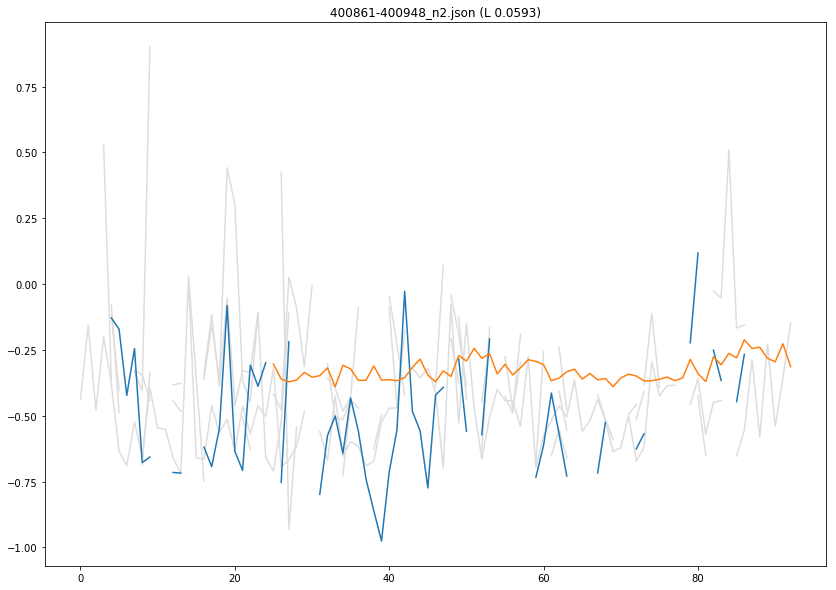

50


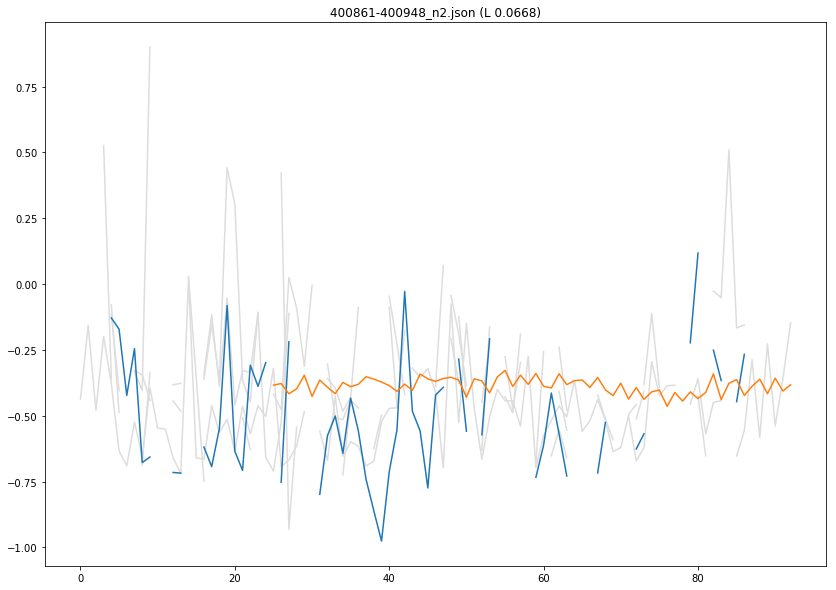

In [184]:
run_plot(gcn, loss_fcn)
run_plot(lin, crit)

In [92]:
## Our MPRNN

In [177]:
from models.MPRNN import MPRNN

comp_segs, comp_adj = complete_graph(segs, adjlist)
# print(comp_adj)
mprnn = MPRNN(comp_segs, comp_adj, hidden_size=128, verbose=True).cuda()
dev = torch.device('cuda:0')
print(dev)
mprnn.device = dev

MPRNN
 [*] Defined over: 5 nodes
 [*] Contains    : 5 adjs
cuda:0


In [178]:
mprnn_params = mprnn.params(lr=0.001)

In [179]:
def post_format(batch, labels=None, lmask=None):
    seq_labels = torch.cat([batch[:, 1:], labels], dim=1) \
        .permute(1, 0).unsqueeze(0).cuda()
    seq_lmask = (1 - torch.isnan(seq_labels).type(torch.ByteTensor)).cuda()

    batch = [tens.squeeze(0) for tens in batch.unsqueeze(1).split(1, 0)]
    batch = [[vel.unsqueeze(0) for vel in seq.squeeze().split(1, 0)] for seq in batch]
    
    return batch, seq_labels, seq_lmask

for epoch in range(5):
    mprnn_params[2].step()
    evaluate(mprnn, mprnn_params[0], post=post_format)

    mprnn.train()
    shuffle(inds)
    for ii, (di, hi) in enumerate(inds):
        batch, labels, lmasks = post_format(*format_batch([(di, hi)], dset.data))

        preds = mprnn(batch)
        loss = mprnn_params[0](preds[lmasks], labels[lmasks])
        
        mprnn_params[1].zero_grad()
        loss.backward()
        mprnn_params[1].step()

        sys.stdout.write('%d/%d  \r' % (ii, len(inds)))
    sys.stdout.write('\n')
    sys.stdout.flush() 

Eval: 0.4382030
3523/3524  
Eval: 0.1297833
3523/3524  
Eval: 0.1284368
3523/3524  
Eval: 0.1309385
3523/3524  
Eval: 0.1321650
3523/3524  


In [181]:
_ = evaluate(mprnn, mprnn_params[0], post=post_format, run=filter_result)

Eval: 0.1362697


50


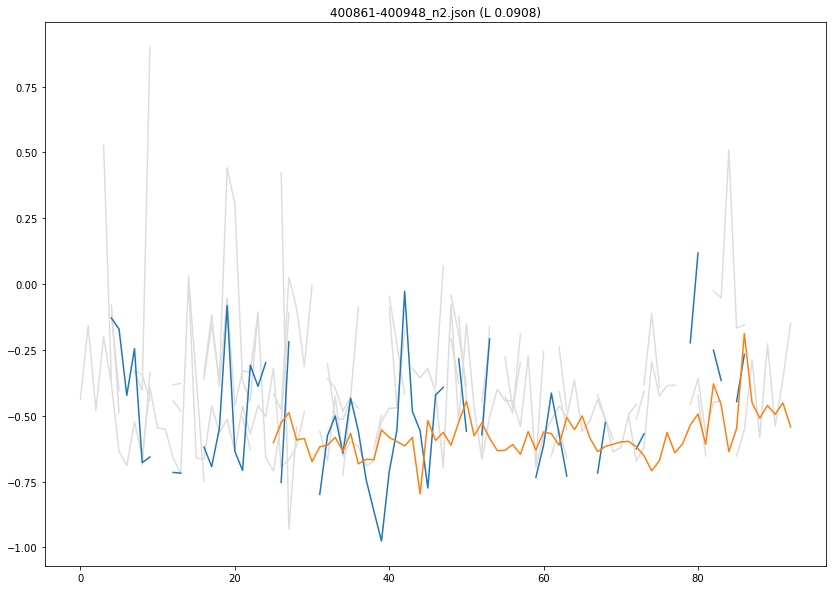

In [185]:
def filter_result(inp):
    return mprnn(inp)[:, -1, :].permute(1, 0)

def last_format(batch, labels=None, lmask=None):
    batch, labels, lmask = post_format(batch, labels, lmask)
    
    return batch, labels[:, -1, :].permute(1, 0), lmask[:, -1, :].permute(1, 0)

run_plot(mprnn, crit=mprnn_params[0], post=last_format, run=filter_result)